In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install tensorflow==2.13.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Directorio principal de las imágenes
dataset_dir = "/content/drive/MyDrive/dataset"
output_dir = "dataset_listo/"

# Crear carpetas para entrenamiento, validación y prueba
for subset in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_dir):
        os.makedirs(os.path.join(output_dir, subset, class_name), exist_ok=True)

# Dividir las imágenes
for class_name in os.listdir(dataset_dir):
    print(class_name)
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)

    if len(images) < 2:
        # Si hay menos de 2 imágenes, todas van al entrenamiento
        train_images = images
        val_images = []
        test_images = []
    elif len(images) < 3:
        # Si hay menos de 3 imágenes, divídelo en entrenamiento y validación
        train_images, val_images = train_test_split(images, train_size=0.7, random_state=42)
        test_images = []
    else:
        # División normal para clases con suficientes imágenes
        train_images, test_images = train_test_split(images, train_size=0.7, random_state=42)

    # Mover imágenes a las carpetas correspondientes
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(output_dir, 'train', class_name))
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(output_dir, 'test', class_name))


Cesar
Jeke
Eve
Gabs
Efram
Jose


In [ ]:
datos_entrenamiento = "dataset_listo/train"
datos_pruebas = "dataset_listo/test"

In [ ]:
# Generador para el conjunto de entrenamiento (con aumentación de datos)
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normalizar píxeles entre 0 y 1
    horizontal_flip=False
)

# Generador para validación y prueba (sin aumentación)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Crear los generadores
train_gen = train_datagen.flow_from_directory(
    datos_entrenamiento,
    target_size=(128, 128),  # Tamaño de las imágenes
    batch_size=32,
    class_mode='categorical' # Para clasificación multiclase
)

test_gen = val_datagen.flow_from_directory(
    datos_pruebas,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 455 images belonging to 6 classes.
Found 199 images belonging to 6 classes.


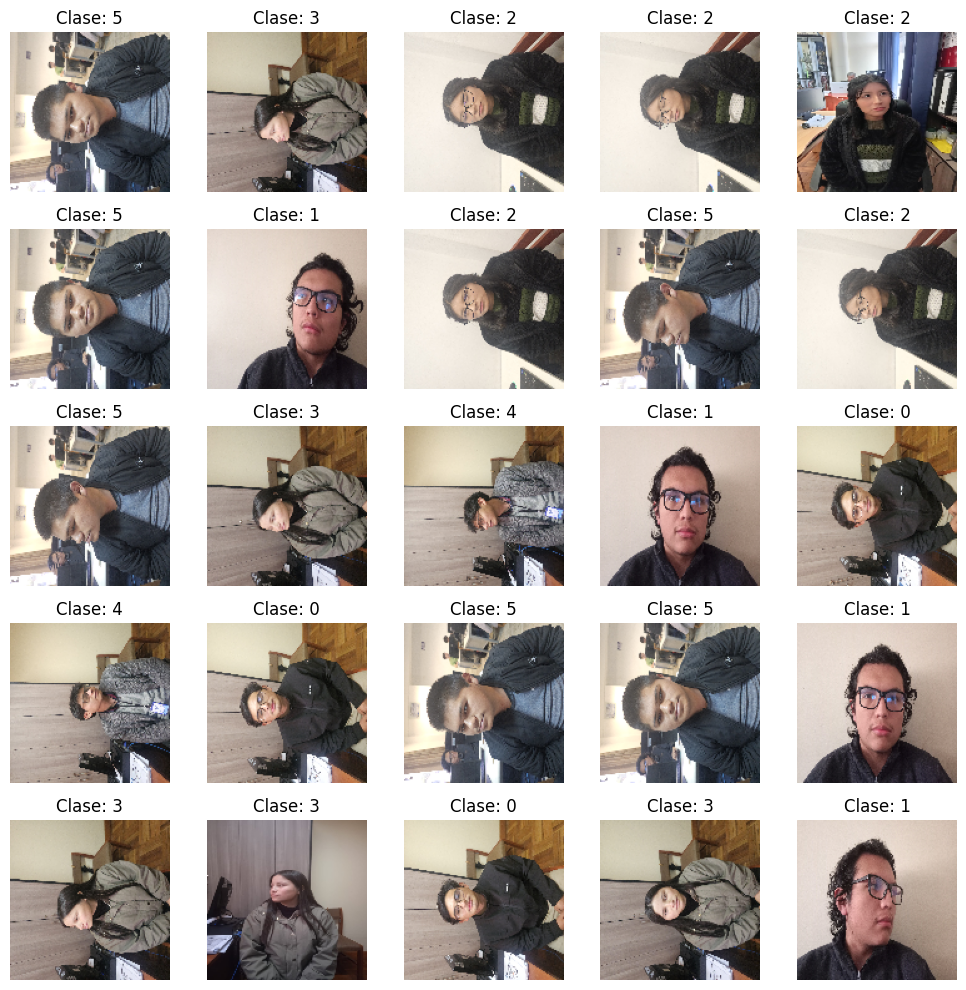

In [ ]:
import matplotlib.pyplot as plt

# Obtén un lote de imágenes y etiquetas del generador
images, labels = next(train_gen)  # Toma el primer lote del generador

# Configurar la cuadrícula para mostrar imágenes
plt.figure(figsize=(10, 10))

# Mostrar las primeras 25 imágenes del lote
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])  # Mostrar la imagen
    plt.title(f"Clase: {labels[i].argmax()}")  # Mostrar la clase (decodificación de one-hot)
    plt.axis('off')  # Ocultar ejes

plt.tight_layout()
plt.show()

In [ ]:
modelo = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 clases (una para cada persona)
])

In [ ]:
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # Para etiquetas one-hot
    metrics=["accuracy"]
)


In [ ]:
import math

#Entrenar
entrnamiento = modelo.fit(
    train_gen,
    epochs=30,
    steps_per_epoch=len(train_gen),
)

Epoch 1/30
15/15 [==============================] - 52s 3s/step - loss: 1.3468 - accuracy: 0.5582
Epoch 2/30
15/15 [==============================] - 50s 3s/step - loss: 0.1810 - accuracy: 0.9407
Epoch 3/30
15/15 [==============================] - 49s 3s/step - loss: 0.0536 - accuracy: 0.9758
Epoch 4/30
15/15 [==============================] - 49s 3s/step - loss: 0.0411 - accuracy: 0.9824
Epoch 5/30
15/15 [==============================] - 49s 3s/step - loss: 0.0181 - accuracy: 0.9956
Epoch 6/30
15/15 [==============================] - 51s 3s/step - loss: 0.0076 - accuracy: 1.0000
Epoch 7/30
 2/15 [===>..........................] - ETA: 50s - loss: 0.0029 - accuracy: 1.0000 

KeyboardInterrupt: 

In [ ]:
modelo.save('modelo.h5')
import tensorflow as tf

# Cargar el modelo guardado en formato H5
model = tf.keras.models.load_model('modelo.h5')

# Convertir el modelo a formato TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo convertido en formato .tflite
with open('modelo.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Cargar una nueva imagen
img = load_img('Copia de WhatsApp Image 2024-11-27 at 12.02.56 PM (1).jpeg', target_size=(128, 128))  # Use load_img directly
img_array = img_to_array(img) / 255.0  # Use img_to_array directly
img_array = np.expand_dims(img_array, axis=0)  # Expandir dimensión para el batch

# Predicción
predictions = modelo.predict(img_array)
predicted_class = np.argmax(predictions)  # Índice de la clase predicha
print(f"Clase predicha: {predicted_class}")


FileNotFoundError: [Errno 2] No such file or directory: 'Copia de WhatsApp Image 2024-11-27 at 12.02.56 PM (1).jpeg'

In [ ]:
import tensorflow as tf
modelo.save('modelo.h5')
# Cargar el modelo guardado en formato H5
model = tf.keras.models.load_model('modelo.h5')

# Convertir el modelo a formato TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo convertido en formato .tflite
with open('modelo.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
